In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import requests

In [2]:
def download_file(url):
    file_path = url.split('/')[-1]
    resp = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(resp.content)
    return file_path

# 1. Redes de colaboração

- Artigos na área de astrofísica
- Publicados entre 1993 e 2003

[Link para o dataset](https://snap.stanford.edu/data/ca-AstroPh.html)

Referência:
- J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.

In [3]:
url = 'https://snap.stanford.edu/data/ca-AstroPh.txt.gz'
file_path = download_file(url)
file_path

'ca-AstroPh.txt.gz'

In [4]:
G = nx.read_edgelist(file_path)
print(G)

Graph with 18772 nodes and 198110 edges


## Densidade da rede

In [5]:
nx.density(G)

0.0011244455715955115

## Conectividade

In [6]:
nx.is_connected(G)

False

Quantas **componentes conexas** existem na rede?

In [7]:
nx.number_connected_components(G)

290

Convertendo para `list` primeiro:

In [8]:
components = nx.connected_components(G)
len(list(components))

290

Tamanho de cada componente

In [9]:
components = nx.connected_components(G)
sizes = []
for comp in components:
    sizes.append(len(comp))

Usando *list comprehension*:

In [10]:
components = nx.connected_components(G)
sizes = [len(comp) for comp in components]

In [11]:
sizes = pd.Series(sizes)
sizes.describe()

count      290.000000
mean        64.731034
std       1051.125146
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max      17903.000000
dtype: float64

Vamos analisar apenas a **maior componente**. Esse é um processo bastante comum.

In [12]:
components = nx.connected_components(G)
nodes = max(components, key=len)
nodes

{'82709',
 '87415',
 '82886',
 '28415',
 '49462',
 '128017',
 '4713',
 '96909',
 '65613',
 '80405',
 '3087',
 '92043',
 '122805',
 '98279',
 '63312',
 '85565',
 '8100',
 '82159',
 '122700',
 '21368',
 '72889',
 '108201',
 '68728',
 '46026',
 '58651',
 '123438',
 '43430',
 '110519',
 '60766',
 '10160',
 '8620',
 '64481',
 '68050',
 '95881',
 '32078',
 '48802',
 '24761',
 '51977',
 '130091',
 '69195',
 '49019',
 '79101',
 '53243',
 '99361',
 '45678',
 '123148',
 '32270',
 '85774',
 '20899',
 '119604',
 '56042',
 '88746',
 '131840',
 '106304',
 '109781',
 '77581',
 '117174',
 '124653',
 '24637',
 '83434',
 '51876',
 '38608',
 '8053',
 '9541',
 '8396',
 '30700',
 '110796',
 '127702',
 '74065',
 '79463',
 '101996',
 '79238',
 '78999',
 '86126',
 '78582',
 '54401',
 '76439',
 '104177',
 '29026',
 '58703',
 '31862',
 '16731',
 '94793',
 '95765',
 '13623',
 '125956',
 '109534',
 '9352',
 '39335',
 '49352',
 '107365',
 '111616',
 '56202',
 '62420',
 '112184',
 '106690',
 '119623',
 '42318',
 '2

In [13]:
H = G.subgraph(nodes)
print(H)

Graph with 17903 nodes and 197031 edges


Percentual de nós e arestas na **maior componente**:

In [14]:
H.number_of_nodes() / G.number_of_nodes()

0.9537076496910292

In [15]:
H.number_of_edges() / G.number_of_edges()

0.9945535308666902

## Distribuição dos graus

### Histograma

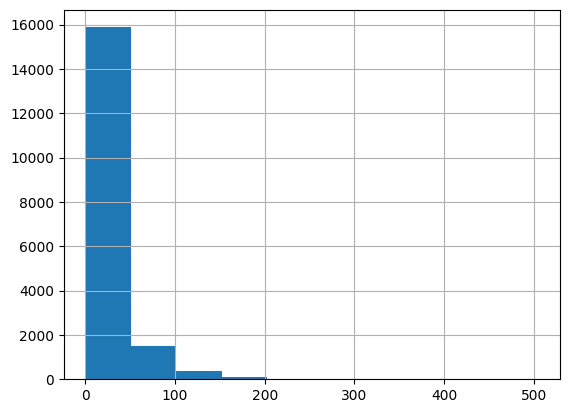

In [16]:
degree_list = [degree for node, degree in H.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

In [17]:
degree_list.describe()

count    17903.000000
mean        22.010948
std         31.016923
min          1.000000
25%          4.000000
50%         10.000000
75%         28.000000
max        504.000000
dtype: float64

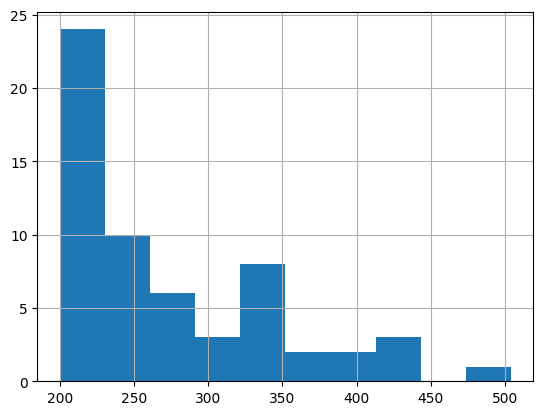

In [18]:
# somente >= 200
degree_list[degree_list >= 200].hist();

### Gráfico de *ranqueamento*

Apesar de ter cauda longa, não parece seguir Lei de Potência

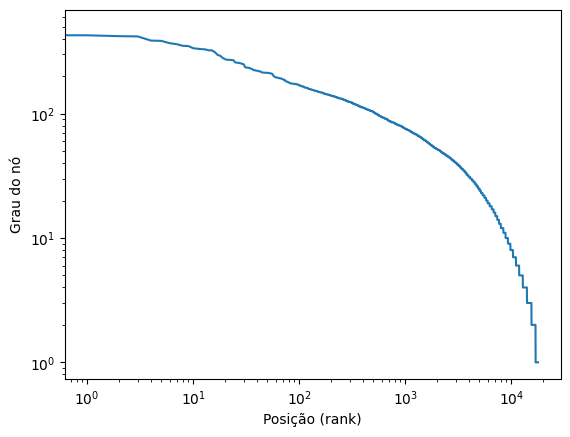

In [19]:
y = degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Cálculo pode ser bastante demorado. Por isso vamos usar o módulo `approximation`:

In [20]:
nx.algorithms.approximation.diameter(H)

14

In [21]:
top_nodes = [node for node, degree in H.degree if degree > 350]
top_nodes

['1086',
 '21718',
 '35290',
 '38109',
 '53213',
 '92790',
 '89732',
 '93504',
 '62821']

In [22]:
# nó 1086 de exemplo
distances = nx.shortest_path_length(H, '1086')
distances = pd.Series(distances)
distances.describe()

count    17903.000000
mean         2.875663
std          0.845950
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          9.000000
dtype: float64

In [23]:
# nó 62821 de exemplo
distances = nx.shortest_path_length(H, '62821')
distances = pd.Series(distances)
distances.describe()

count    17903.000000
mean         2.858459
std          0.844698
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          9.000000
dtype: float64

## Clusterização

Mais uma vez, vamos usar uma **aproximação**:

In [24]:
nx.algorithms.approximation.average_clustering(H)

0.62

## Comparação com rede aleatória Erdös-Rényi

In [25]:
num_nodes = G.number_of_nodes()
density = nx.density(G)
random_graph = nx.erdos_renyi_graph(num_nodes, density, seed=42)
print(random_graph)

Graph with 18772 nodes and 197308 edges


### Clusterização

In [26]:
nx.algorithms.approximation.average_clustering(H)

0.662

In [27]:
nx.algorithms.approximation.average_clustering(random_graph)

0.0

### Número de componentes

In [28]:
nx.number_connected_components(G)

290

In [29]:
nx.number_connected_components(random_graph)

1

### Diâmetro

In [30]:
nx.algorithms.approximation.diameter(H)

14

In [31]:
nx.algorithms.approximation.diameter(random_graph)

5

### Distribuição dos graus

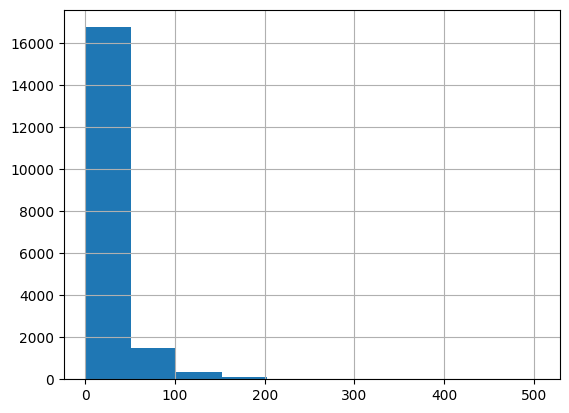

In [32]:
degree_list = [degree for node, degree in G.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

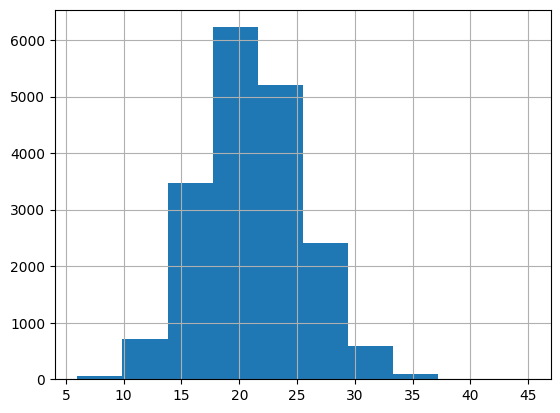

In [33]:
rng_degree_list = [degree for node, degree in random_graph.degree]
rng_degree_list = pd.Series(rng_degree_list)
rng_degree_list.hist();

# 2. Internet

"*Fotografia*" tirada em novembro de 2007

[Link para o dataset](https://snap.stanford.edu/data/as-Caida.html)

Referência:
- J. Leskovec, J. Kleinberg and C. Faloutsos. Graphs over Time: Densification Laws, Shrinking Diameters and Possible Explanations. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2005.

In [34]:
url = 'https://snap.stanford.edu/data/as-caida20071105.txt.gz'
file_path = download_file(url)
file_path

'as-caida20071105.txt.gz'

In [35]:
G = nx.read_weighted_edgelist(file_path)
print(G)

Graph with 26475 nodes and 53381 edges


## Densidade da rede

Dez vezes menor do que a rede de colaboração!

In [36]:
nx.density(G)

0.0001523214859084934

## Conectividade

Faz sentido que a rede seja conectada:

In [37]:
nx.is_connected(G)

True

Só existe uma **componente conexa** na rede:

In [38]:
nx.number_connected_components(G)

1

## Distribuição dos graus

### Histograma

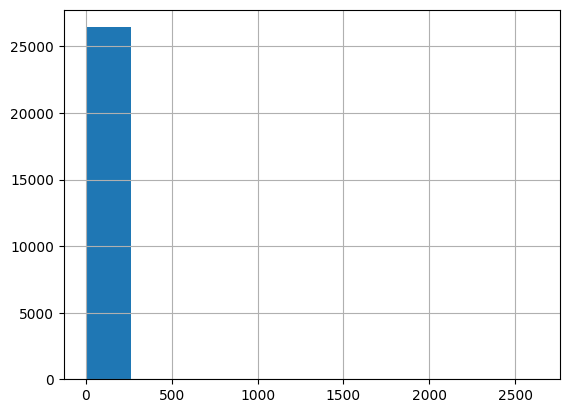

In [39]:
degree_list = [degree for node, degree in G.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

In [40]:
degree_list.describe()

count    26475.000000
mean         4.032559
std         33.374795
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max       2628.000000
dtype: float64

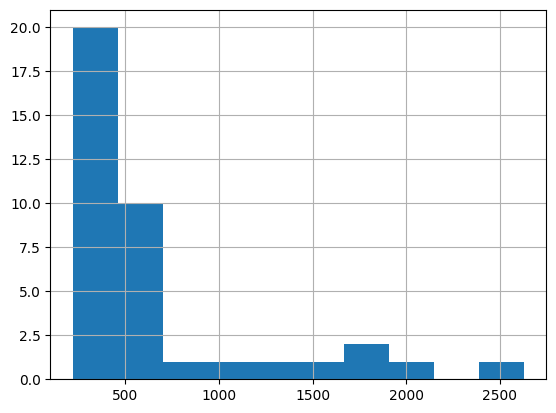

In [41]:
degree_list[degree_list>200].hist();

### Gráfico de *ranqueamento*

Provavelmente uma Lei de Potência!

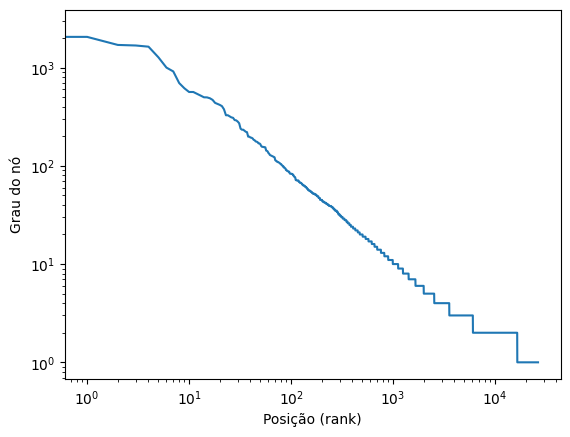

In [42]:
y = degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Novamente usaremos a aproximação:

In [43]:
nx.algorithms.approximation.diameter(G)

17

In [44]:
top_nodes = [node for node, degree in G.degree if degree > 1500]
top_nodes

['174', '3356', '7018', '701', '1239']

In [45]:
distances = nx.shortest_path_length(G, '174')
distances = pd.Series(distances)
distances.describe()

count    26475.000000
mean         2.421870
std          0.728787
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         13.000000
dtype: float64

In [46]:
distances = nx.shortest_path_length(G, '3356')
distances = pd.Series(distances)
distances.describe()

count    26475.000000
mean         2.330538
std          0.675398
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         13.000000
dtype: float64

## Clusterização

Três vezes menor do que a da *Rede de colaboração*:

In [47]:
nx.algorithms.approximation.average_clustering(G)

0.213

## Comparação com rede aleatória Erdös-Rényi

In [48]:
num_nodes = G.number_of_nodes()
density = nx.density(G)
random_graph = nx.erdos_renyi_graph(num_nodes, density, seed=42)
print(random_graph)

Graph with 26475 nodes and 53285 edges


### Clusterização

In [49]:
nx.algorithms.approximation.average_clustering(G)

0.218

In [50]:
nx.algorithms.approximation.average_clustering(random_graph)

0.0

### Número de componentes

In [51]:
nx.number_connected_components(G)

1

In [52]:
nx.number_connected_components(random_graph)

474

### Diâmetro

In [53]:
nx.algorithms.approximation.diameter(G)

17

In [54]:
# nx.algorithms.approximation.diameter(random_graph)

Maior componente conexa do grafo aleatório:

In [55]:
components = nx.connected_components(random_graph)
nodes = max(components, key=len)
random_graph_comp = random_graph.subgraph(nodes)
print(random_graph_comp)

Graph with 25980 nodes and 53263 edges


In [56]:
nx.algorithms.approximation.diameter(random_graph_comp)

15

### Distribuição dos graus

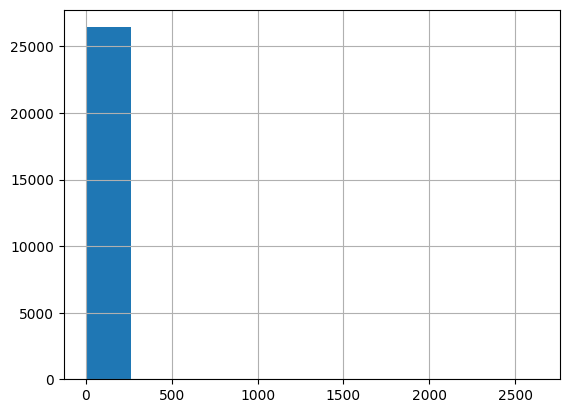

In [57]:
degree_list = [degree for node, degree in G.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

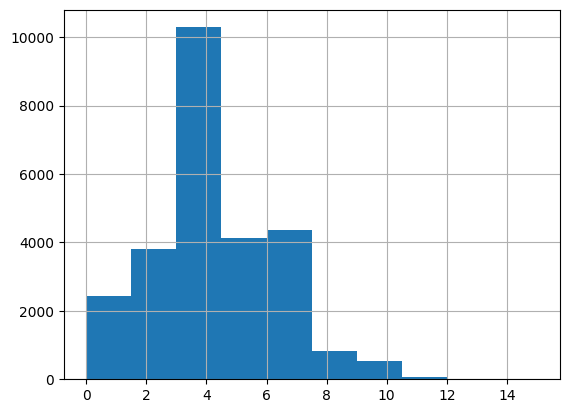

In [58]:
rng_degree_list = [degree for node, degree in random_graph.degree]
rng_degree_list = pd.Series(rng_degree_list)
rng_degree_list.hist();

# 3. Estradas

- Rede rodoviária do estado da Pensilvânia, EUA.
- Rede **direcionada**.

[Link para o dataset](https://snap.stanford.edu/data/roadNet-PA.html)

Referência:
- J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.

In [59]:
url = 'https://snap.stanford.edu/data/roadNet-PA.txt.gz'
file_path = download_file(url)
file_path

'roadNet-PA.txt.gz'

Essa rede pode demorar para carregar!

In [60]:
G = nx.read_edgelist(file_path, create_using=nx.DiGraph)
print(G)

DiGraph with 1088092 nodes and 3083796 edges


## Densidade da rede

Muito menor do que as outras! Por quê?

In [61]:
nx.density(G)

2.6046825795723353e-06

## Conectividade

Fortemente conexo -> caminho de **ida e volta**

In [62]:
nx.is_strongly_connected(G)

False

Quantas **componentes conexas fortes** existem na rede?

In [63]:
nx.number_strongly_connected_components(G)

206

Separando a **maior componente conexa forte**:

In [64]:
components = nx.strongly_connected_components(G)
nodes = max(components, key=len)
H = G.subgraph(nodes)
print(H)

DiGraph with 1087562 nodes and 3083028 edges


Percentual de nós e arestas na **maior componente**:

In [65]:
H.number_of_nodes() / G.number_of_nodes()

0.9995129088349147

In [66]:
H.number_of_edges() / G.number_of_edges()

0.9997509562889374

## Distribuição dos graus

### Histograma

Grau de entrada:

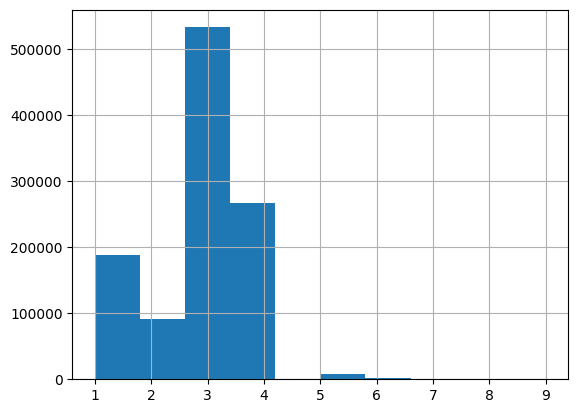

In [67]:
in_degree_list = [degree for node, degree in G.in_degree]
in_degree_list = pd.Series(in_degree_list)
in_degree_list.hist();

In [68]:
in_degree_list.describe()

count    1.088092e+06
mean     2.834132e+00
std      1.016930e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      9.000000e+00
dtype: float64

Grau de saída:

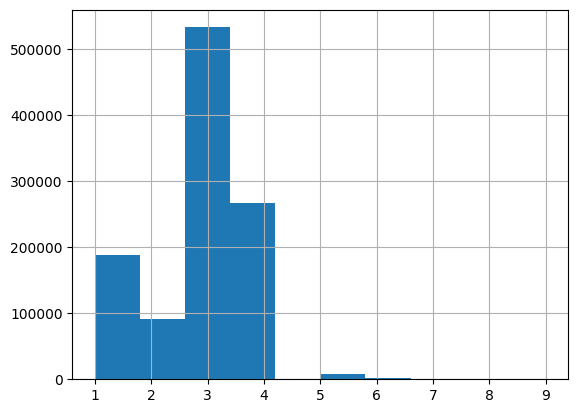

In [69]:
out_degree_list = [degree for node, degree in G.out_degree]
out_degree_list = pd.Series(out_degree_list)
out_degree_list.hist();

In [70]:
out_degree_list.describe()

count    1.088092e+06
mean     2.834132e+00
std      1.016930e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      9.000000e+00
dtype: float64

### Gráfico de *ranqueamento*

Certamente não segue Lei de Potência:

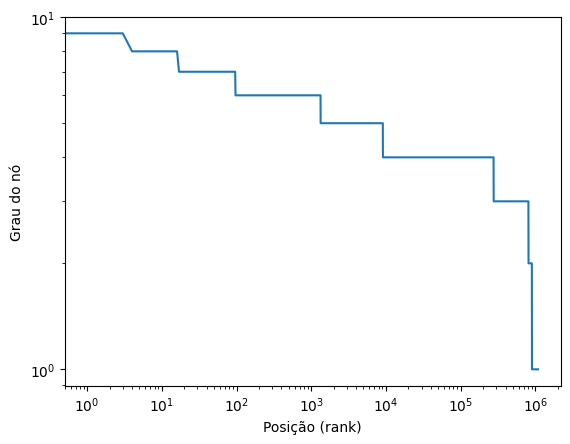

In [71]:
y = in_degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Limite inferior para o diâmetro:

In [72]:
nx.algorithms.approximation.diameter(H)

794

In [73]:
distances = nx.shortest_path_length(H, '0')
distances = pd.Series(distances)
distances.describe()

count    1.087562e+06
mean     2.857163e+02
std      1.085169e+02
min      0.000000e+00
25%      2.070000e+02
50%      2.940000e+02
75%      3.610000e+02
max      5.410000e+02
dtype: float64

## Clusterização

Vamos criar uma cópia **não direcionada** da rede:

In [74]:
undirected = nx.to_undirected(H)
print(undirected)

Graph with 1087562 nodes and 1541514 edges


Clusterização muito pequena! Faz sentido?

In [75]:
nx.algorithms.approximation.average_clustering(undirected)

0.046

## Comparação com rede aleatória Erdös-Rényi

Rede muito grade -> **equações**

In [76]:
n = G.number_of_nodes()
p = nx.density(G)
n, p

(1088092, 2.6046825795723353e-06)

### Clusterização

Cada aresta tem probabilidade `p` de existir, a chance de haver uma aresta entre vizinhos é `p`

In [77]:
random_graph_clustering = p
random_graph_clustering

2.6046825795723353e-06

### Número de componentes

Componente gigante surge se grau médio é **maior do que 1**!

In [78]:
mean_degree = p * (n - 1)
mean_degree

2.834131672689442

### Diâmetro

Em uma rede aleatória, pode ser estimado pelo **número de nós** e **grau médio**:

In [79]:
random_graph_diameter = np.log(n) / np.log(mean_degree)
random_graph_diameter

13.343055795874397

### Distribuição dos graus

Graus seguem uma **Distribuição Binomial**:

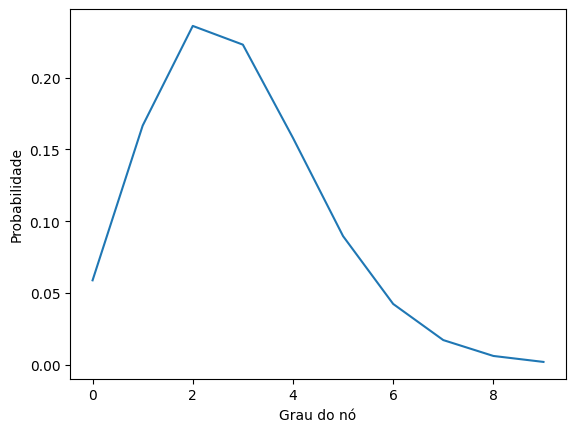

In [80]:
degree_dist = scipy.stats.binom(n - 1, p)
x = np.arange(10)
y = degree_dist.pmf(x)
plt.plot(x, y)
plt.xlabel('Grau do nó')
plt.ylabel('Probabilidade');

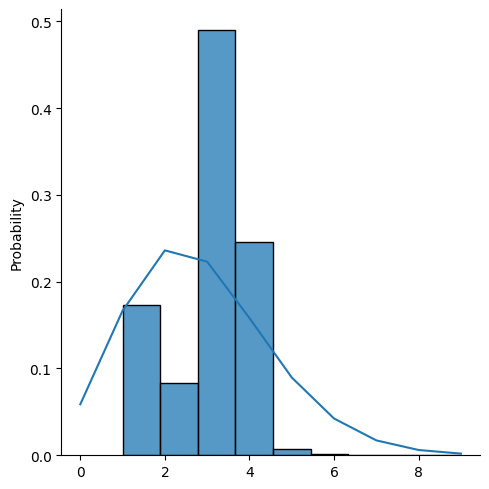

In [81]:
sns.displot(in_degree_list, stat='probability', bins=9)
plt.plot(x, y);

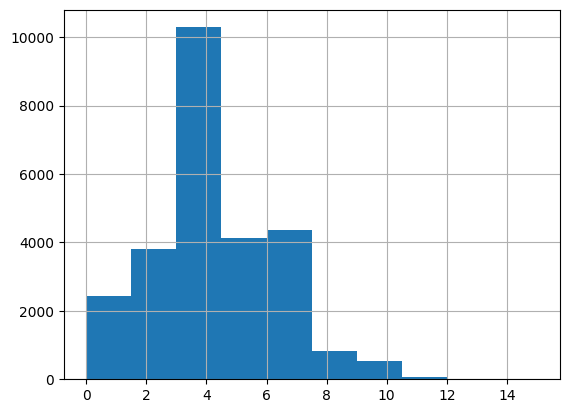

In [82]:
rng_degree_list = [degree for node, degree in random_graph.degree]
rng_degree_list = pd.Series(rng_degree_list)
rng_degree_list.hist();

# 4. Redes sociais

- Rede social do site [Slashdot](https://slashdot.org/)
- Aresta *friend or foe*

[Link para o dataset](https://snap.stanford.edu/data/soc-Slashdot0811.html)

Referência:
- J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.

In [83]:
url = 'https://snap.stanford.edu/data/soc-Slashdot0811.txt.gz'
file_path = download_file(url)
file_path

'soc-Slashdot0811.txt.gz'

In [84]:
G = nx.read_edgelist(file_path, create_using=nx.DiGraph)
print(G)

DiGraph with 77360 nodes and 905468 edges


## Densidade da rede

Muito parecida com a densidade da Internet!

In [85]:
nx.density(G)

0.0001513023935343928

## Conectividade

Fortemente conexo -> caminho de **ida e volta**

In [86]:
nx.is_strongly_connected(G)

False

Muitas **componentes conexas fortes**!

In [87]:
nx.number_strongly_connected_components(G)

6724

Separando a **maior componente conexa forte**:

In [88]:
components = nx.strongly_connected_components(G)
nodes = max(components, key=len)
H = G.subgraph(nodes)
print(H)

DiGraph with 70355 nodes and 888662 edges


Percentual de nós e arestas na **maior componente**:

In [89]:
H.number_of_nodes() / G.number_of_nodes()

0.9094493278179938

In [90]:
H.number_of_edges() / G.number_of_edges()

0.9814394324261045

Menor conectividade quando comparada às outras redes

## Distribuição dos graus

### Histograma

Grau de entrada:

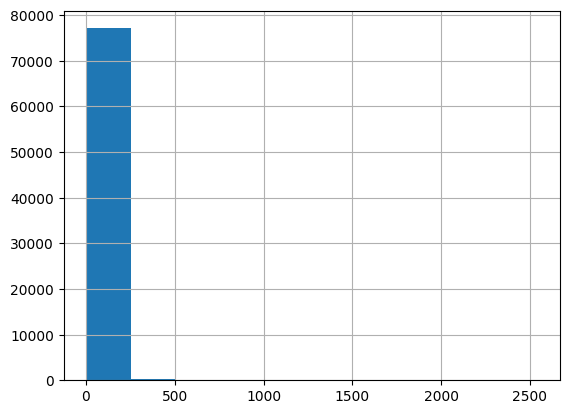

In [91]:
in_degree_list = [degree for node, degree in G.in_degree]
in_degree_list = pd.Series(in_degree_list)
in_degree_list.hist();

In [92]:
in_degree_list.describe()

count    77360.000000
mean        11.704602
std         37.205199
min          1.000000
25%          2.000000
50%          3.000000
75%          8.000000
max       2540.000000
dtype: float64

Grau de saída:

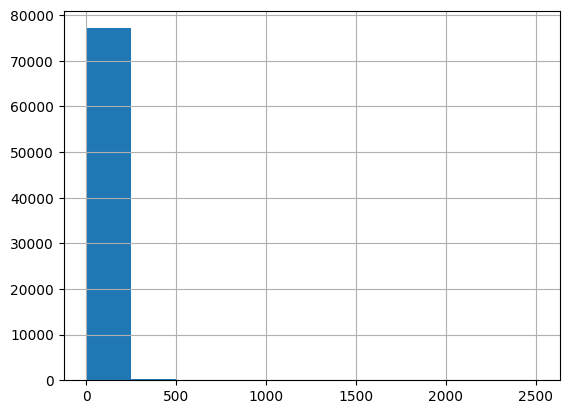

In [93]:
out_degree_list = [degree for node, degree in G.out_degree]
out_degree_list = pd.Series(out_degree_list)
out_degree_list.hist();

In [94]:
out_degree_list.describe()

count    77360.000000
mean        11.704602
std         36.844128
min          0.000000
25%          2.000000
50%          3.000000
75%          7.000000
max       2508.000000
dtype: float64

Graus de entrada e saída são parecidos

### Gráfico de *ranqueamento*

Será que segue Lei de Potência?

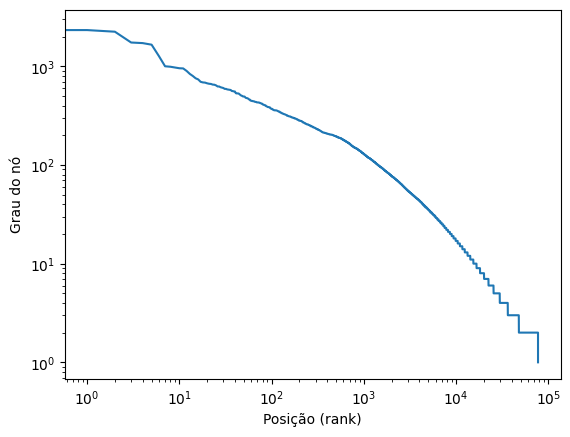

In [95]:
y = in_degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Limite inferior para o diâmetro:

In [96]:
nx.algorithms.approximation.diameter(H)

12

In [97]:
distances = nx.shortest_path_length(H, '0')
distances = pd.Series(distances)
distances.describe()

count    70355.00000
mean         3.09435
std          0.66968
min          0.00000
25%          3.00000
50%          3.00000
75%          3.00000
max          7.00000
dtype: float64

## Clusterização

Vamos criar uma cópia **não direcionada** da rede:

In [98]:
undirected = nx.to_undirected(H)
print(undirected)

Graph with 70355 nodes and 529972 edges


Como em muitas redes sociais, clusterização é alta!

In [99]:
nx.algorithms.approximation.average_clustering(undirected)

0.576

## Comparação com rede aleatória Erdös-Rényi

Vamos aproveitar as equações!

In [100]:
n = G.number_of_nodes()
p = nx.density(G)
n, p

(77360, 0.0001513023935343928)

### Clusterização

Certamente não é uma rede aleatória!

In [101]:
random_graph_clustering = p
random_graph_clustering

0.0001513023935343928

### Número de componentes

Com grau médio > 1, tendência de formar uma **componente gigante**

In [102]:
mean_degree = p * (n - 1)
mean_degree

11.704601861427093

### Diâmetro

Na rede aleatória, esperamos um diâmetro menor:

In [103]:
random_graph_diameter = np.log(n) / np.log(mean_degree)
random_graph_diameter

4.575734593499139

### Distribuição dos graus

Graus seguem uma **Distribuição Binomial**:

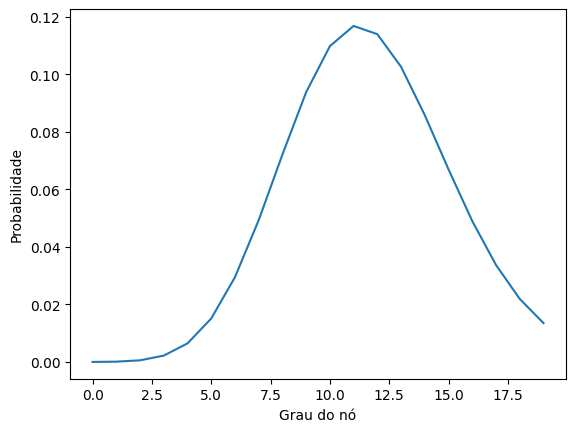

In [104]:
degree_dist = scipy.stats.binom(n - 1, p)
x = np.arange(20)
y = degree_dist.pmf(x)
plt.plot(x, y)
plt.xlabel('Grau do nó')
plt.ylabel('Probabilidade');

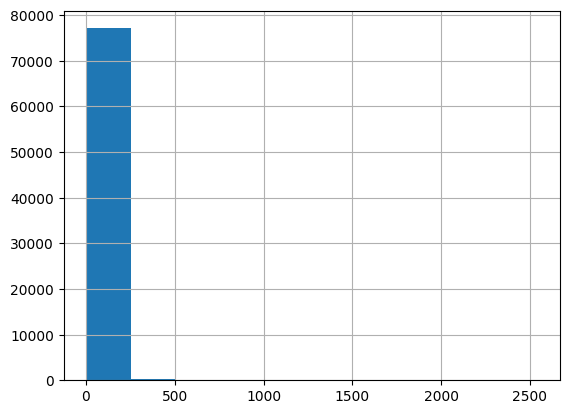

In [105]:
in_degree_list.hist();